In [3]:
import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [4]:
path = '/opt/ml/input/data/'
# # train = pd.read_csv(path + 'train_data.csv')
# # test = pd.read_csv(path + 'test_data.csv')
dat = pd.read_csv(path + 'FE_total_2_elo2.csv')

dat = dat.sort_values(by = ['userID', 'Timestamp'])
dat['tem'] = 0


In [5]:
dat.drop(['last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10'], axis = 1, inplace = True)

In [6]:

_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] == -1]

In [7]:
_train['userID'].value_counts()

730     1860
481     1847
1112    1777
394     1774
926     1773
        ... 
7373      14
7252      13
7414      13
7390      13
7441       9
Name: userID, Length: 7442, dtype: int64

In [8]:
def elo(df):
    def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + learning_rate_theta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - learning_rate_beta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def learning_rate_theta(nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    def learning_rate_beta(nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    def probability_of_good_answer(theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def estimate_parameters(answers_df, granularity_feature_name="assessmentItemID"):
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(
                answers_df[granularity_feature_name]
            )
        }
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print("Parameter estimation is starting...", flush=True)

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            ),
            total=len(answers_df),
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = get_new_beta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        return student_parameters, item_parameters
        




    df["left_asymptote"] = 0

    print(f"Dataset of shape {df.shape}")
    print(f"Columns are {list(df.columns)}")

    student_parameters, item_parameters = estimate_parameters(df)

    
    t = [
        student_parameters[student]["theta"]
        for student, item in zip(df.userID.values, df.assessmentItemID.values)
    ]
    


    #theta represents the global level of the student
    df['elouser'] = t

    return df


In [9]:
# 데이터 증강하는 법.
def data_argument(train):
    _train = train.copy()
    _train.reset_index(drop = True, inplace= True)
    _train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'tem'] = -1
    _valid = _train[_train['tem'] == -1]
    _train = _train[_train['tem'] == 0]

    return _train, _valid

_train_x, _valid = data_argument(_train)
# _train_x_1, _train_1 = data_argument(_train_x)
# _train_x_2, _train_2 = data_argument(_train_x_1)
# _train_x_3, _train_3 = data_argument(_train_x_2)
# _train_x_4, _train_4 = data_argument(_train_x_3)
# _train_x_5, _train_5 = data_argument(_train_x_4)
# _train_x_6, _train_6 = data_argument(_train_x_5)
# _train_x_7, _train_7 = data_argument(_train_x_6)
# _train_x_8, _train_8 = data_argument(_train_x_7)
# _train_x_9, _train_9 = data_argument(_train_x_8)
# _train_x_10, _train_10 = data_argument(_train_x_9)

In [10]:
def data_merge(_train_x, _train_y): 
    # _train_x : 값 제공하는 전체 DB, _train_y : 현재 맞춰야 하는 유저와 아이템 상태.

    # 문제별로 평균값, 총 풀어진 개수 구하기.
    item1 = _train_x.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    item1.columns = ["item_mean", 'item_sum']
    item1.reset_index(inplace=True)
    _train_x = pd.merge(_train_x, item1[['assessmentItemID','item_mean']], on=['assessmentItemID'], how='left')

    # 유저 단위 변수 추가

    # 유저가 평균적으로 얼마나 맞는지, 또 몇 문제 풀었는지.
    tem1 = _train_x.groupby('userID')['answerCode']
    tem1 = pd.DataFrame({'answer_mean' : tem1.mean(), 'answer_cnt':tem1.count()}).reset_index()
    # 유저가 평균적으로 몇 분안에 문제를 풀었는지.
    tem2 = _train_x.groupby('userID')['solve_time']
    tem2 = pd.DataFrame({'time_mean' : tem2.mean()}).reset_index()
    # 유저의 태그를 붙인 것 같은데 정확히 뭔지 모르겠음. => 최빈 태그라고 함(mode)
    tem3 = pd.DataFrame({'tag_mode' : _train_x.groupby('userID')['KnowledgeTag'].agg(pd.Series.mode)})
    tem3['tag_mode'] = tem3['tag_mode'].apply(lambda x : x if str(type(x)) =="<class 'numpy.int64'>" else x[0])
    # 유저가 지금까지 푼 문제의 평균 정답률은 어떻게 되는지 구하기.(어려운 문제를 풀어왔는가?)
    tem5 = _train_x.groupby(['userID'])['item_mean'].agg(['mean']).reset_index()
    
    tem5.columns = ["userID", 'user_item_mean']
    # tem4 = _train_x.groupby('userID')['answerCode'].apply(lambda x : x.iloc[-3:])
    # tem4 = pd.DataFrame({'last3_mean' : tem4.groupby('userID').mean()})
    
    tmp = _train_x.groupby('userID').tail(100)
    tmp = elo(tmp)
    tmp = tmp.drop(columns=["left_asymptote"])


    tem6 = pd.DataFrame(tmp.groupby(['userID'])['elouser'].tail(1)).reset_index().reset_index()
    tem6 = tem6.drop(['index'],axis=1)
    tem6.columns = ["userID", 'elouser']

        
    user_df = pd.merge(tem1, tem2, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem3, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem5, on=['userID'], how='left')
    user_df = pd.merge(user_df, tem6, on=['userID'], how='left')
    # user_df = pd.merge(user_df, tem4, on=['userID'], how='left')
    
    _train_y = pd.merge(_train_y[['userID', 'assessmentItemID', 'answerCode','last_answerCode',
    'last_answerCode2','last_answerCode3','last_answerCode4','last_answerCode5','last_answerCode6']], user_df, on=['userID'], how='left')

    # 아이템 단위 변수 추가.

    # 해당 문제는 평균 정답률이 어떻게 되는가? + 학생이 몇 번이나 풀었던가?
    _train_y = pd.merge(_train_y, item1, on=['assessmentItemID'], how='left')
    # 해당 문제는 평균 풀이 시간이 어떻게 되는가?
    item2 = _train_x.groupby(['assessmentItemID'])['solve_time'].agg(['mean'])
    item2.columns = ["item_time_mean"]
    item2.reset_index(inplace=True)
    _train_y = pd.merge(_train_y, item2, on=['assessmentItemID'], how='left')

    return _train_y.drop(['userID','assessmentItemID'],axis=1)

test = data_merge(_train, _test)
valid = data_merge(_train_x, _valid)

/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (630107, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 630107/630107 [00:14<00:00, 44663.59it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (627840, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 627840/627840 [00:14<00:00, 44383.62it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


In [11]:
valid

,answerCode,last_answerCode,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,answer_mean,answer_cnt,time_mean,tag_mode,user_item_mean,elouser,item_mean,item_sum,item_time_mean
0,0,0,1,0,1,1,0,0.631720,744,3.183573e+04,4784,0.656187,0.514004,0.157459,57,1471.690608
1,1,1,1,1,1,0,1,0.853004,932,2.890081e+04,2010,0.585533,1.628445,0.478261,11,22951.869565
2,0,0,0,0,0,0,0,0.614545,275,8.923406e+04,307,0.662057,0.328292,0.125000,30,139.725000
3,0,1,1,1,1,1,1,0.693424,1034,2.432358e+04,2616,0.670097,0.646806,0.425703,106,103.281124
4,1,1,1,1,0,1,1,0.693572,669,4.131957e+04,2065,0.611423,0.320060,0.652778,94,79.944444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,0,1,0,0,0,0,0,0.400000,15,3.384340e+05,2076,0.775111,-0.693594,0.867470,216,35.220884
7438,1,1,1,0,1,1,1,0.733333,15,1.362587e+06,2132,0.767696,0.009523,0.561224,165,60.853741
7439,1,1,1,0,1,0,0,0.714286,14,1.694699e+06,2132,0.753885,0.093830,0.829431,248,86.839465
7440,0,0,0,0,1,0,0,0.428571,14,3.897256e+05,1984,0.750708,-0.732877,0.574074,155,143.370370


In [12]:
_train_x_1, _train_1 = data_argument(_train_x)
train_1 = data_merge(_train_x_1, _train_1)
train = train_1.copy()

for _ in range(50):
    _train_x_1, _train_1 = data_argument(_train_x_1)
    train_1 = data_merge(_train_x_1, _train_1)
    train = pd.concat([train, train_1])

train = train[train['answer_cnt'] >= 14]

/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (625552, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 625552/625552 [00:14<00:00, 42164.17it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (623253, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 623253/623253 [00:13<00:00, 44709.89it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (620941, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 620941/620941 [00:14<00:00, 44064.18it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (618610, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 618610/618610 [00:14<00:00, 43140.38it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (616261, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 616261/616261 [00:13<00:00, 44073.11it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (613903, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 613903/613903 [00:13<00:00, 44367.26it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (611526, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 611526/611526 [00:14<00:00, 42035.23it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (609132, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 609132/609132 [00:14<00:00, 42448.42it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (606723, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 606723/606723 [00:13<00:00, 44595.08it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (604294, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 604294/604294 [00:13<00:00, 44553.82it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (601853, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 601853/601853 [00:13<00:00, 44748.63it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (599398, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 599398/599398 [00:13<00:00, 44662.89it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (596932, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 596932/596932 [00:13<00:00, 44446.29it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (594472, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 594472/594472 [00:13<00:00, 44860.18it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (592033, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 592033/592033 [00:13<00:00, 44585.23it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (589628, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 589628/589628 [00:13<00:00, 44889.63it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (587263, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 587263/587263 [00:13<00:00, 44807.87it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (584937, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 584937/584937 [00:13<00:00, 43486.07it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (582637, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 582637/582637 [00:13<00:00, 44452.54it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (580361, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 580361/580361 [00:13<00:00, 44469.50it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (578117, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 578117/578117 [00:12<00:00, 44636.40it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (575881, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 575881/575881 [00:12<00:00, 44663.21it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (573676, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 573676/573676 [00:12<00:00, 44752.36it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (571497, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 571497/571497 [00:12<00:00, 44604.46it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (569332, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 569332/569332 [00:12<00:00, 44518.24it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (567188, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 567188/567188 [00:12<00:00, 44682.95it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (565066, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 565066/565066 [00:12<00:00, 44270.00it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (562969, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 562969/562969 [00:12<00:00, 44196.78it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (560901, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 560901/560901 [00:13<00:00, 42850.41it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (558860, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 558860/558860 [00:12<00:00, 44955.15it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (556839, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 556839/556839 [00:12<00:00, 44486.81it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (554830, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 554830/554830 [00:12<00:00, 44432.33it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (552852, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 552852/552852 [00:12<00:00, 44607.41it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (550890, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 550890/550890 [00:12<00:00, 42597.21it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (548952, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 548952/548952 [00:12<00:00, 44439.85it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (547039, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 547039/547039 [00:12<00:00, 44391.73it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (545142, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 545142/545142 [00:12<00:00, 44520.22it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (543261, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 543261/543261 [00:12<00:00, 44526.94it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (541388, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 541388/541388 [00:12<00:00, 44539.51it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (539525, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 539525/539525 [00:12<00:00, 44648.30it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (537686, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 537686/537686 [00:12<00:00, 44060.98it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (535865, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 535865/535865 [00:12<00:00, 44124.88it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (534058, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 534058/534058 [00:11<00:00, 44542.38it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (532268, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 532268/532268 [00:11<00:00, 44802.15it/s]


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t
/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (530501, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 530501/530501 [00:11<00:00, 44673.69it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (528751, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 528751/528751 [00:12<00:00, 41956.60it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (527017, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 527017/527017 [00:11<00:00, 44542.39it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (525306, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 525306/525306 [00:11<00:00, 44685.03it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (523608, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 523608/523608 [00:11<00:00, 44816.78it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (521930, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 521930/521930 [00:12<00:00, 43188.49it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


/tmp/ipykernel_93623/502413999.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["left_asymptote"] = 0


Dataset of shape (520267, 29)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time', 'b_category', 'test_category', 'problem_id', 'category_st_qcut_5', 'last_answerCode', 'last_answerCode2', 'last_answerCode3', 'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'year', 'month', 'day', 'hour', 'tem', 'item_mean', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 520267/520267 [00:11<00:00, 44808.74it/s]
/tmp/ipykernel_93623/502413999.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elouser'] = t


Theta & beta estimations on assessmentItemID are completed.


In [21]:
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import optuna
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


def objective(trial, train, valid, train_value, valid_value):
    param = {
        "random_state" : 1998, 
        "n_estimators" : 10000, 
        "learning_rate" : 0.001,
        "max_depth" : trial.suggest_int("max_depth", 8, 12),
        "num_leaves" : 30, 
        "subsample" : 0.9,
        "verbose" : 200
    }
    
    model = LGBMClassifier(**param)
    model.fit(train, train_value, eval_metric = 'AUC', eval_set=(valid, valid_value))
    
    preds = model.predict_proba(train_value)[:,1]

    acc = accuracy_score(train_value, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(train_value, preds)
    print(f'TRAIN AUC : {auc} ACC : {acc}\n')

    preds = model.predict_proba(valid_value)[:,1]
    acc = accuracy_score(valid_value, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(valid_value, preds)

    print(f'VALID AUC : {auc} ACC : {acc}\n')

    return auc

In [ ]:
import optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(lambda trial : objective(trial, train.drop(['answerCode'],axis=1), valid.drop(['answerCode'],axis=1), train['answerCode'], valid['answerCode']), n_trials=5)

Text(0.5, 1.0, 'Feature Importance')

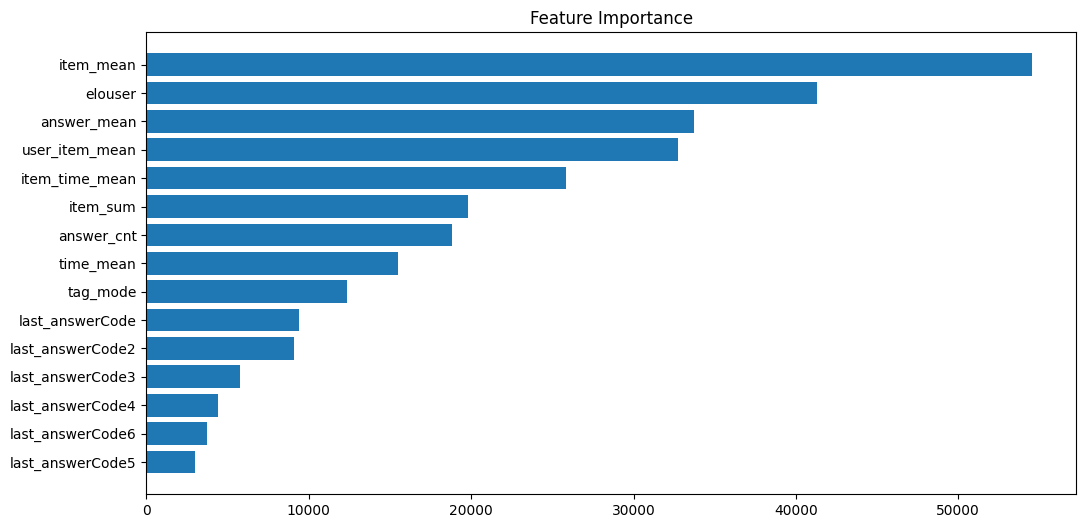

In [ ]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(valid.drop(['answerCode'],axis=1).columns)[sorted_idx])
plt.title("Feature Importance")

In [ ]:
# submission 제출하기 위한 코드

test_pred = model.predict_proba(test.drop(['answerCode'],axis=1))[:,1]
test['prediction'] = test_pred
submission = test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/sequence_50LGBM1204.csv', index = False)